# 1. Dependencies

In [1]:
import os, sys
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio
import numpy as np
import pandas as pd

2023-09-21 17:57:08.444813: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2. Data

In [228]:
NORMAL_DIR = os.path.join('data', 'Normal')
TB_DIR  = os.path.join('data', 'Tuberculosis')

In [289]:
normal = tf.data.Dataset.list_files(NORMAL_DIR + '/*.png')
tb = tf.data.Dataset.list_files(TB_DIR + '/*.png')

In [290]:
len(normal), len(tb)

(1760, 700)

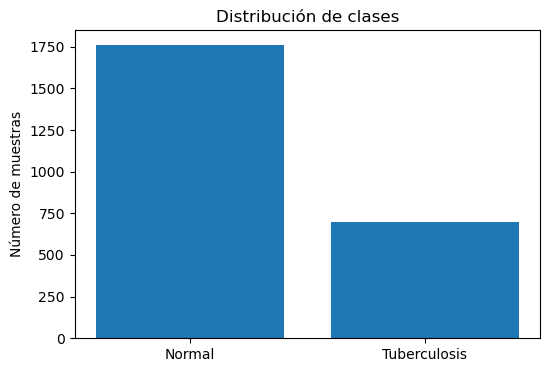

In [56]:
clase_0_count = len(normal)
clase_1_count = len(tb)

# Crear un gráfico de barras
plt.figure(figsize=(6, 4))
plt.bar(['Normal', 'Tuberculosis'], [clase_0_count, clase_1_count])
plt.ylabel('Número de muestras')
plt.title('Distribución de clases')
plt.show()

Clases imbalanceadas!!!

In [230]:
normal.as_numpy_iterator().next()

b'data/Normal/Normal-470.png'

# 3. Create tensorflow dataset

In [231]:
#Add labels and combine positive and negative samples
normal_data = tf.data.Dataset.zip((normal, tf.data.Dataset.from_tensor_slices(tf.zeros(len(normal))))) #0
tb_data = tf.data.Dataset.zip((tb, tf.data.Dataset.from_tensor_slices(tf.ones(len(tb))))) #1
data = normal_data.concatenate(tb_data)

In [232]:
data.as_numpy_iterator().next()

(b'data/Normal/Normal-761.png', 0.0)

In [235]:
item = data.as_numpy_iterator().next()
item[0], item[1]

(b'data/Normal/Normal-1218.png', 0.0)

# 4. Preprocessing

In [236]:
from PIL import Image

In [237]:
@tf.function
def preprocess(file_path, label):
    # Decode the PNG image
    xray_data = tf.io.read_file(file_path)
    xray_image = tf.image.decode_png(xray_data, channels=1) 
    
    # Redimensionar la imagen a las dimensiones deseadas (512x512)
    #spectrogram_image = tf.image.resize(spectrogram_image, [512, 512])

    # Convert the image to a tensor
    xray = tf.cast(xray_image, tf.float32) / 255.0  # Scale to [0, 1]
    
    return xray, label

In [238]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(batch_size=8)
data = data.prefetch(8)

In [239]:
sample, label = data.as_numpy_iterator().next()

2023-09-21 18:32:58.999567: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [240]:
sample

array([[[[0.9098039 ],
         [0.9019608 ],
         [0.89411765],
         ...,
         [0.93333334],
         [0.9607843 ],
         [0.80784315]],

        [[0.88235295],
         [0.87058824],
         [0.85882354],
         ...,
         [0.90588236],
         [0.92941177],
         [0.79607844]],

        [[0.8509804 ],
         [0.8509804 ],
         [0.8392157 ],
         ...,
         [0.8862745 ],
         [0.92156863],
         [0.7764706 ]],

        ...,

        [[0.07450981],
         [0.07450981],
         [0.07450981],
         ...,
         [0.26666668],
         [0.3372549 ],
         [0.30980393]],

        [[0.07450981],
         [0.07450981],
         [0.07450981],
         ...,
         [0.26666668],
         [0.3372549 ],
         [0.30980393]],

        [[0.07450981],
         [0.07450981],
         [0.07450981],
         ...,
         [0.27058825],
         [0.32941177],
         [0.3019608 ]]],


       [[[0.21568628],
         [0.23137255],
         [0.17

In [241]:
sample.shape # (batch, px, px, channels)

(8, 512, 512, 1)

In [242]:
label

array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

# 5. Train, test and validation data 

In [243]:
total_size = len(data)
train_size = int(len(data)*0.70)
val_size = int(len(data)*0.15)
test_size = int(len(data)*0.15)

total_size, train_size, val_size, test_size

(308, 215, 46, 46)

In [244]:
train = data.take(train_size+1)
test = data.skip(train_size+1).take(test_size)
val = data.skip(train_size+test_size+1).take(val_size)

In [294]:
len(train), len(test), len(val)

(216, 46, 46)

In [296]:
test == val #I make sure they are not the same data

False

In [245]:
samples, labels = train.as_numpy_iterator().next()

2023-09-22 15:49:07.679855: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [248]:
samples.shape #x-ray image has the shape of (512,512,1)

(8, 512, 512, 1)

In [250]:
labels

array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [251]:
model_input_shape = (samples.shape[1], samples.shape[2], samples.shape[3])
model_input_shape

(512, 512, 1)

In [252]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

# 6. Build, compile and fit the model

In [253]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout

In [254]:
model = Sequential()

#Input layers
model.add(Conv2D(32, (3,3), activation='relu', input_shape=model_input_shape))
model.add(MaxPooling2D((2, 2)))

#1st Hidden layers
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

#2nd Hidden layers
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

#3rd Hideen layers group
model.add(Flatten())
model.add(Dense(128, activation='relu'))

#Output layer
#model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [255]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [256]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 510, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 255, 255, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 126, 126, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 64)      36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 62, 62, 64)        0

In [257]:
hist = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
216/216 [==============================] - 382s 2s/step - loss: 0.4983 - recall: 0.7479 - precision: 0.8012 - val_loss: 0.2859 - val_recall: 0.9639 - val_precision: 0.8500
Epoch 2/10
216/216 [==============================] - 340s 2s/step - loss: 0.4658 - recall: 0.6883 - precision: 0.7637 - val_loss: 0.4564 - val_recall: 0.8571 - val_precision: 0.8571
Epoch 3/10
216/216 [==============================] - 330s 2s/step - loss: 0.2304 - recall: 0.7596 - precision: 0.8649 - val_loss: 0.2295 - val_recall: 0.9239 - val_precision: 0.9055
Epoch 4/10
216/216 [==============================] - 325s 2s/step - loss: 0.1587 - recall: 0.8516 - precision: 0.8684 - val_loss: 0.1725 - val_recall: 0.9741 - val_precision: 0.9353
Epoch 5/10
216/216 [==============================] - 327s 2s/step - loss: 0.1051 - recall: 0.8994 - precision: 0.9161 - val_loss: 0.1148 - val_recall: 0.9830 - val_precision: 0.9105
Epoch 6/10
216/216 [==============================] - 319s 1s/step - loss: 0.0721 - r

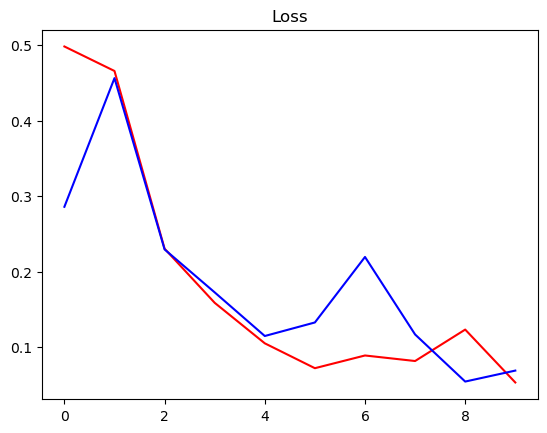

In [258]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

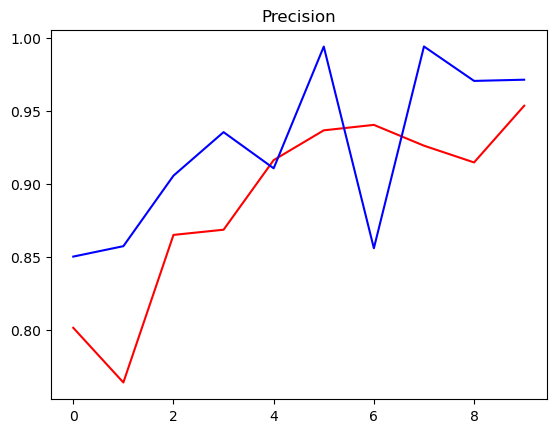

In [260]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

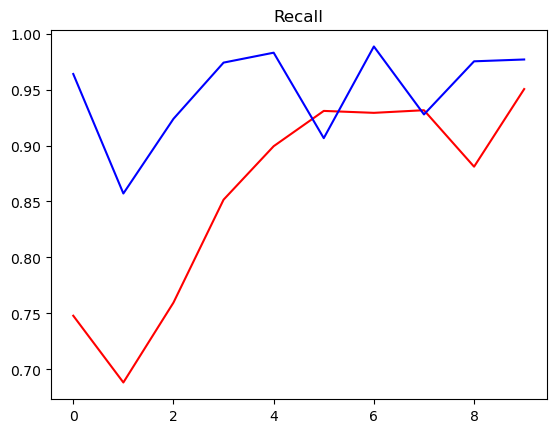

In [261]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

# 7. Save the model

In [297]:
model.save('model.h5')

/Users/guillecanovas/opt/anaconda3/envs/stock-analysis/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
stored_model = keras.models.load_model('model.h5')

# 8. Test predictions with one batch

In [262]:
X_test, y_test = test.as_numpy_iterator().next()

In [263]:
X_test.shape

(8, 512, 512, 1)

In [270]:
yhat = model.predict(X_test)
yhat

1/1 [==============================] - 0s 317ms/step


array([[1.5842364e-14],
       [9.9815845e-01],
       [9.9890059e-01],
       [2.0907743e-07],
       [9.9108344e-01],
       [9.2747396e-01],
       [9.7491562e-01],
       [9.9718308e-01]], dtype=float32)

In [271]:
yhat = [1 if prediction > 0.90 else 0 for prediction in yhat]
yhat

[0, 1, 1, 0, 1, 1, 1, 1]

In [272]:
y_test.astype(int)

array([0, 1, 1, 0, 1, 1, 1, 1])

In [273]:
y_test.astype(int) == yhat

array([ True,  True,  True,  True,  True,  True,  True,  True])

# 9. Final Test predictions

In [300]:
X_test_list = []
y_test_list = []

# Iterate over the entire 'test' dataset and store the concatenations
for X_batch, y_batch in test.as_numpy_iterator():
    X_test_list.append(X_batch)
    y_test_list.append(y_batch)

X_test = np.concatenate(X_test_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)

In [301]:
yhat = model.predict(X_test)
yhat[:10]

12/12 [==============================] - 15s 1s/step


array([[9.8270112e-01],
       [9.6969893e-03],
       [9.9995250e-01],
       [6.7822212e-01],
       [3.9147248e-04],
       [6.5686239e-09],
       [8.8258314e-01],
       [9.9224937e-01],
       [9.9881899e-01],
       [0.0000000e+00]], dtype=float32)

In [303]:
yhat = [1 if prediction > 0.99 else 0 for prediction in yhat]
yhat[:10]

[1, 0, 1, 0, 0, 0, 0, 1, 1, 0]

In [304]:
y_test.astype(int)

array([1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,

In [305]:
predictions = (y_test.astype(int) == yhat)
predictions[:40]

array([ True,  True,  True, False,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True, False])

# 10. Calculate precision

In [306]:
# Calculate True Positives (count of True values)
true_positives = np.sum(predictions)

# Calculate False Positives (count of False values)
false_positives = len(predictions) - true_positives

# Calculate Precision
precision = true_positives / (true_positives + false_positives)

print("Precision:", precision)

Precision: 0.9347826086956522


# 11. Image enhancement technique (TO DO)

Five different image enhancement techniques: 
- Histogram equalization (HE)
- Contrast limited adaptive histogram equalization (CLAHE)
- Image complement
- __Gamma correction (Works really well)__ 
- Balance Contrast Enhancement Technique (BCET)

These techniques are implemented by reffering the below paper.
Ref paper: https://arxiv.org/pdf/2012.02238.pdf